<a href="https://colab.research.google.com/github/mohamedshouaib/iti/blob/main/DeepLearning/CNN/fashion_mnist_assignment_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms
import time

import numpy as np
import random
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)


# Data

In [49]:

transform = transforms.ToTensor()

training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

training_loader = torch.utils.data.DataLoader(training_set, batch_size=128, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')


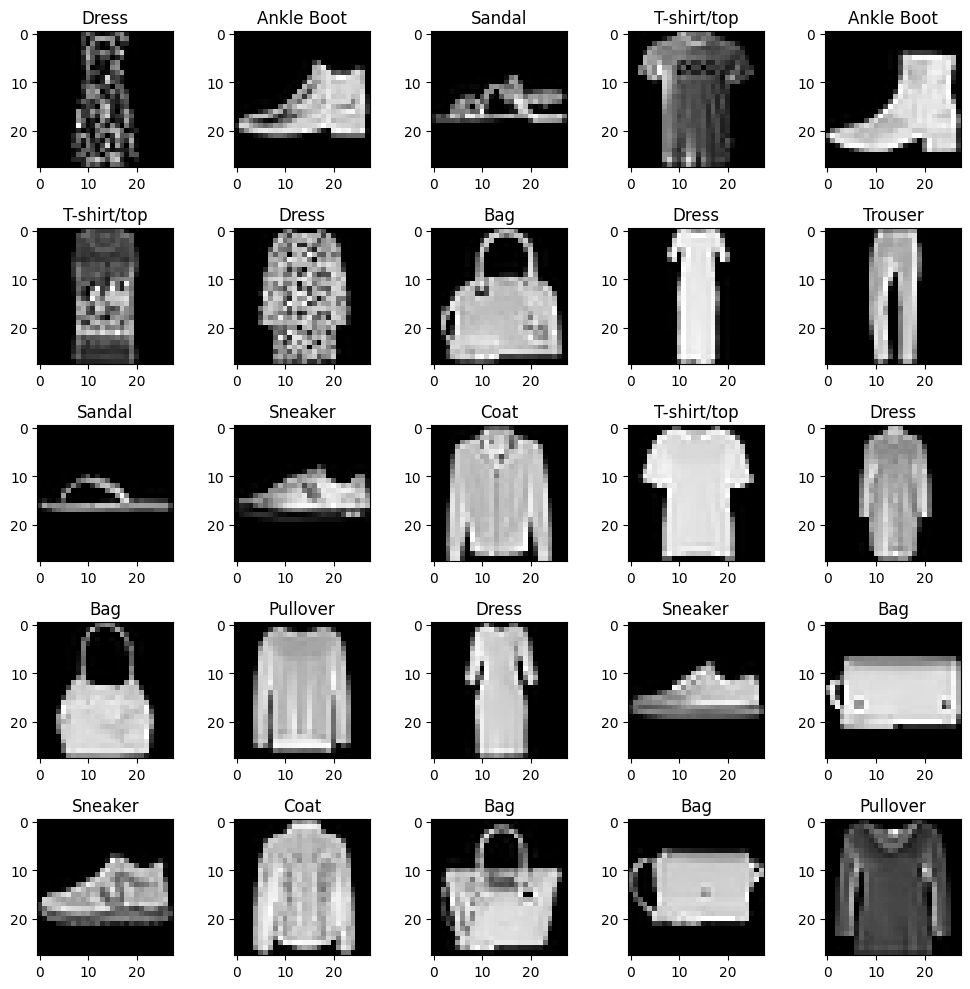

In [50]:
batch = next(iter(training_loader))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(*batch)):
    if i > 24:
        break
    plt.subplot(5, 5, i + 1)
    plt.imshow(image[0], cmap="gray")
    plt.title(classes[label])

plt.tight_layout()

# Exercise

In [51]:
# Define MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [52]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [53]:
class FashionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Additional conv layers for better feature extraction
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)

        # Classifier
        self.fc1 = nn.Linear(128*7*7, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        x = self.pool(torch.relu(self.conv4(x)))

        # Classifier
        x = x.view(-1, 128*7*7)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [54]:
def train_model(model, name):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_acc = []
    test_acc = []
    start_time = time.time()

    for epoch in range(15):
        # Training
        model.train()
        correct = 0
        total = 0

        with tqdm(training_loader, unit="batch", desc=f"{name} Epoch {epoch+1}") as tepoch:
            for images, labels in tepoch:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                tepoch.set_postfix(loss=loss.item(), accuracy=100.*correct/total)

        train_acc.append(100 * correct / total)

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in validation_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc.append(100 * correct / total)

        print(f'Train Acc: {train_acc[-1]:.2f}% | Test Acc: {test_acc[-1]:.2f}%')
        print('-'*50)

    training_time = time.time() - start_time
    print(f'{name} training completed in {training_time:.2f} seconds\n')
    return train_acc, test_acc, training_time

In [55]:
# Train both models
mlp = MLP()
cnn = CNN()
cnn2 = FashionCNN()

In [56]:
print("Training MLP...")
mlp_train_acc, mlp_test_acc, mlp_time = train_model(mlp, "MLP")

Training MLP...


MLP Epoch 1: 100%|██████████| 469/469 [00:13<00:00, 33.66batch/s, accuracy=80.9, loss=0.467]


MLP Epoch 1:
Train Acc: 80.94% | Test Acc: 84.39%
--------------------------------------------------


MLP Epoch 2: 100%|██████████| 469/469 [00:14<00:00, 32.83batch/s, accuracy=86.6, loss=0.462]


MLP Epoch 2:
Train Acc: 86.58% | Test Acc: 84.77%
--------------------------------------------------


MLP Epoch 3: 100%|██████████| 469/469 [00:13<00:00, 33.56batch/s, accuracy=87.9, loss=0.302]


MLP Epoch 3:
Train Acc: 87.94% | Test Acc: 87.41%
--------------------------------------------------


MLP Epoch 4: 100%|██████████| 469/469 [00:14<00:00, 33.50batch/s, accuracy=88.9, loss=0.331]


MLP Epoch 4:
Train Acc: 88.92% | Test Acc: 87.95%
--------------------------------------------------


MLP Epoch 5: 100%|██████████| 469/469 [00:14<00:00, 33.49batch/s, accuracy=89.4, loss=0.246]


MLP Epoch 5:
Train Acc: 89.41% | Test Acc: 87.23%
--------------------------------------------------


MLP Epoch 6: 100%|██████████| 469/469 [00:14<00:00, 32.24batch/s, accuracy=89.9, loss=0.207]


MLP Epoch 6:
Train Acc: 89.87% | Test Acc: 87.57%
--------------------------------------------------


MLP Epoch 7: 100%|██████████| 469/469 [00:14<00:00, 33.40batch/s, accuracy=90.4, loss=0.229]


MLP Epoch 7:
Train Acc: 90.44% | Test Acc: 88.45%
--------------------------------------------------


MLP Epoch 8: 100%|██████████| 469/469 [00:14<00:00, 33.33batch/s, accuracy=90.8, loss=0.203]


MLP Epoch 8:
Train Acc: 90.76% | Test Acc: 88.95%
--------------------------------------------------


MLP Epoch 9: 100%|██████████| 469/469 [00:14<00:00, 33.45batch/s, accuracy=91.3, loss=0.249]


MLP Epoch 9:
Train Acc: 91.26% | Test Acc: 88.96%
--------------------------------------------------


MLP Epoch 10: 100%|██████████| 469/469 [00:14<00:00, 33.03batch/s, accuracy=91.5, loss=0.274]


MLP Epoch 10:
Train Acc: 91.53% | Test Acc: 88.96%
--------------------------------------------------


MLP Epoch 11: 100%|██████████| 469/469 [00:14<00:00, 33.07batch/s, accuracy=91.9, loss=0.221]


MLP Epoch 11:
Train Acc: 91.92% | Test Acc: 88.94%
--------------------------------------------------


MLP Epoch 12: 100%|██████████| 469/469 [00:14<00:00, 33.45batch/s, accuracy=92.1, loss=0.131]


MLP Epoch 12:
Train Acc: 92.11% | Test Acc: 89.08%
--------------------------------------------------


MLP Epoch 13: 100%|██████████| 469/469 [00:14<00:00, 31.61batch/s, accuracy=92.5, loss=0.183]


MLP Epoch 13:
Train Acc: 92.49% | Test Acc: 88.69%
--------------------------------------------------


MLP Epoch 14: 100%|██████████| 469/469 [00:14<00:00, 32.83batch/s, accuracy=92.9, loss=0.208]


MLP Epoch 14:
Train Acc: 92.94% | Test Acc: 89.00%
--------------------------------------------------


MLP Epoch 15: 100%|██████████| 469/469 [00:14<00:00, 33.29batch/s, accuracy=93.1, loss=0.185]


MLP Epoch 15:
Train Acc: 93.06% | Test Acc: 89.30%
--------------------------------------------------
MLP training completed in 233.12 seconds



In [57]:
print("\nTraining CNN...")
cnn_train_acc, cnn_test_acc, cnn_time = train_model(cnn, "CNN")


Training CNN...


CNN Epoch 1: 100%|██████████| 469/469 [01:10<00:00,  6.65batch/s, accuracy=81.5, loss=0.341]


CNN Epoch 1:
Train Acc: 81.49% | Test Acc: 85.73%
--------------------------------------------------


CNN Epoch 2: 100%|██████████| 469/469 [01:11<00:00,  6.54batch/s, accuracy=87.8, loss=0.392]


CNN Epoch 2:
Train Acc: 87.81% | Test Acc: 88.47%
--------------------------------------------------


CNN Epoch 3:  61%|██████    | 284/469 [00:43<00:28,  6.47batch/s, accuracy=89.4, loss=0.268]


KeyboardInterrupt: 

In [ ]:
print("\nTraining CNN_2...")
cnn_train_acc2, cnn_test_acc2, cnn_time2 = train_model(cnn2, "FashionCNN")

In [ ]:
# Plot results
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(mlp_test_acc, label='MLP Test Accuracy')
plt.plot(cnn_test_acc, label='CNN Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Comparison')
plt.legend()

In [ ]:
# Final metrics comparison
plt.subplot(1, 2, 2)
metrics = ['Final Test Acc', 'Training Time']
mlp_values = [mlp_test_acc[-1], mlp_time]
cnn_values = [cnn_test_acc[-1], cnn_time]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, mlp_values, width, label='MLP')
plt.bar(x + width/2, cnn_values, width, label='CNN')
plt.xticks(x, metrics)
plt.ylabel('Value')
plt.title('Model Comparison')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Print final comparison
print("\nFinal Comparison:")
print(f"MLP - Test Accuracy: {mlp_test_acc[-1]:.2f}%, Training Time: {mlp_time:.2f}s")
print(f"CNN - Test Accuracy: {cnn_test_acc[-1]:.2f}%, Training Time: {cnn_time:.2f}s")